# Robust estimation
In this notebook we will explore the effects of really nasty noise on the estimation of LTI models. α-Sub Gaussian noise is both highly impulsive and correlated in time, making it the perfect candidate to corrupt our simulated measurement signals with. This kind of noise is common in shallow seawater as the common snapping shrimp produces noise with approximately this distribution.

We start by generating some signals and some noise

In [29]:
using ControlSystemIdentification, ControlSystems, AlphaStableDistributions, DSP, TotalLeastSquares, Plots, Statistics, Random
gr(show=false)
Random.seed!(0)
N = 10_000   # Number of samples
f = 100_000  # Sampling frequency
t = LinRange(0,N/f,N)

F = [2000, 8000, 10000, 15000, 25000] # Vector of frequencies that make up the signal
na = 2length(F) # The order of AR models we're going to fit. Two poles per frequency peak in the spectrum are required.
y = sum(sin.(2π*f .* t) for f in F); # The clean signal

Below, we draw a sample from the `AlphaSubGaussian` distribution with default parameters and plot this noise together with the clean signal.

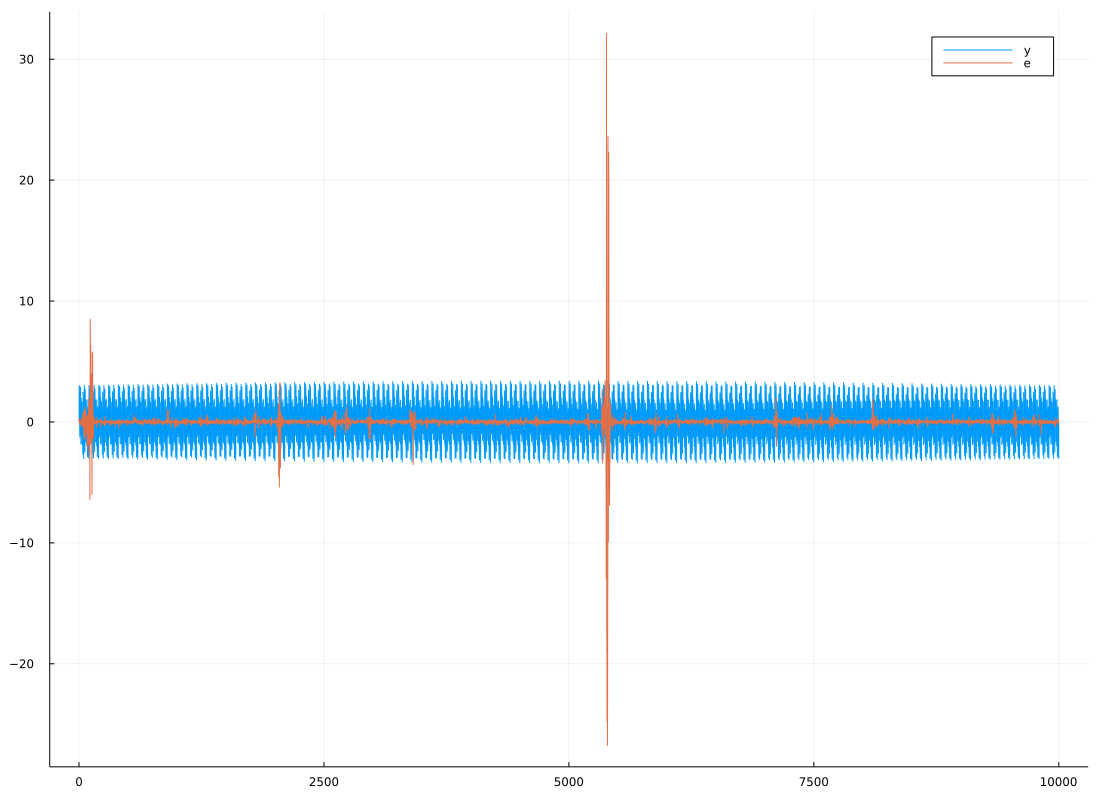

In [30]:
e = rand(AlphaSubGaussian(n=N))
e ./= std(e)
plot([y e], lab=["y" "e"])

Next, we estimate AR models in a number of different ways and plot their spectra. We do tihs for several different intensities of the noise.In order to not clutter the plot too much, I have commented some of the lines, feel free to reproduce the plot with those models added.

σ = 0.0001
σ = 

0.00031622776601683794


σ = 0.001
σ = 

0.0031622776601683794


σ = 0.01
σ = 

0.03162277660168379


σ = 0.1
σ = 

0.31622776601683794


σ = 1.0


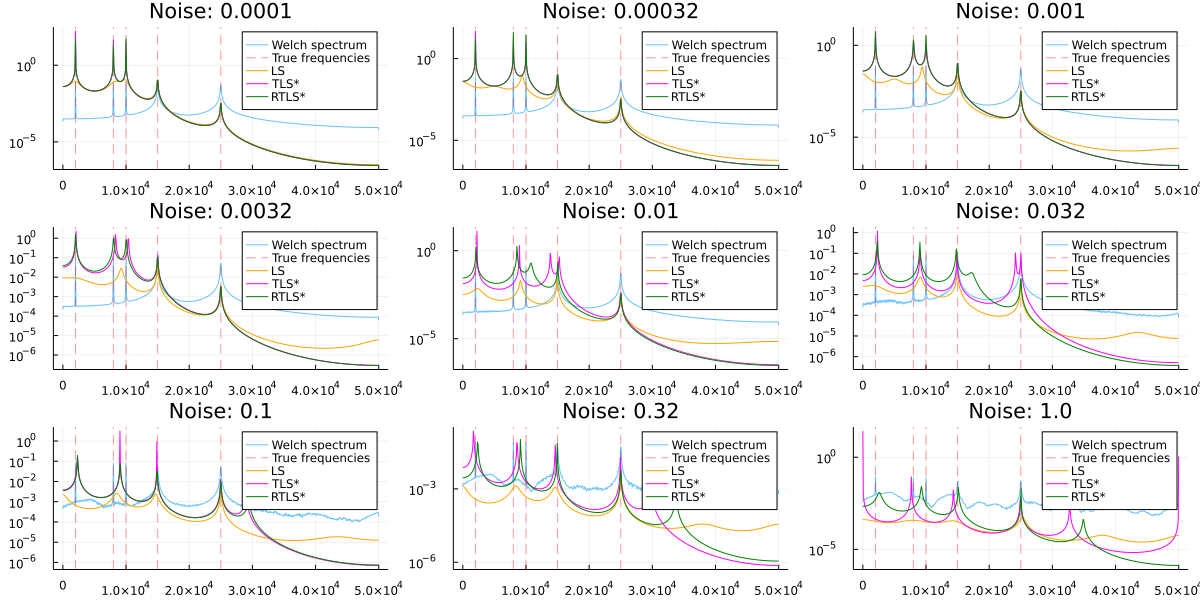

In [31]:
σvec = exp10.(LinRange(-4, 0, 9)) # Vector of noise intensities
figs = map(σvec) do σ
    @show σ
    yn = y + σ*e # Form the noisy signal

    P = welch_pgram(yn, fs=f) # Estimate Welch spectrum
    freqs = Vector(P.freq)
    fig = plot(freqs, .√P.power, yscale=:log10, lab="Welch spectrum", title="Noise: $(round(σ, sigdigits=2))", alpha=0.6)
    vline!(F, l=(:red, :dash, 0.4), lab="True frequencies")

    d = iddata(yn, 1/f)
    Gls = ar(d, na)
    b = bodev(Gls, 2pi .* freqs)[1]
    plot!(freqs, b./N, lab="LS", c=:orange)


    yn = lowrankfilter(yn, 80)

    Gtls = ar(d, na, estimator=tls)
    b = bodev(Gtls, 2pi .* freqs)[1]
    plot!(freqs, b./N, lab="TLS*", c=:magenta)

    robust = (A,y)->TotalLeastSquares.rtls(A,y,iters=400, tol=2e-6)
    Grtls = ar(d, na, estimator=robust)
    b = bodev(Grtls, 2pi .* freqs)[1]
    plot!(freqs, b./N, lab="RTLS*", c=:green)

    fig
end
plot(figs..., size=(1200,600))

As we can see, the standard least-squares (LS) estimate does not model the signal very well. Total least-squares `tls` does a better job, and robust estimates using robust total least squares `rtls` does even better. Notice also the line `yn = lowrankfilter(yn, 50)`. This filters the signal by forming a lag-embedding `H` and estimating a separation of the embedding matrix into a low-rank matrix and a sparse noise matrix `H = L + S`. You can try removing tihs line and see how the performance degrades.

This `lowrankfilter` is actually really neat, we can see how well it removes the noise from the signal as a function of the embedding dimension `n`:

In [32]:
yn = y + e # Form the noisy signal
e0 = ControlSystemIdentification.rms(y-yn) # This is the error without filtering

0.9999711771346735

In [33]:
nvec = round.(Int, exp10.(LinRange(1, 2.8, 12)))
fits = map(nvec) do n
    yh = lowrankfilter(yn, n, tol=1e-3)
    ControlSystemIdentification.rms(y-yh)
end;

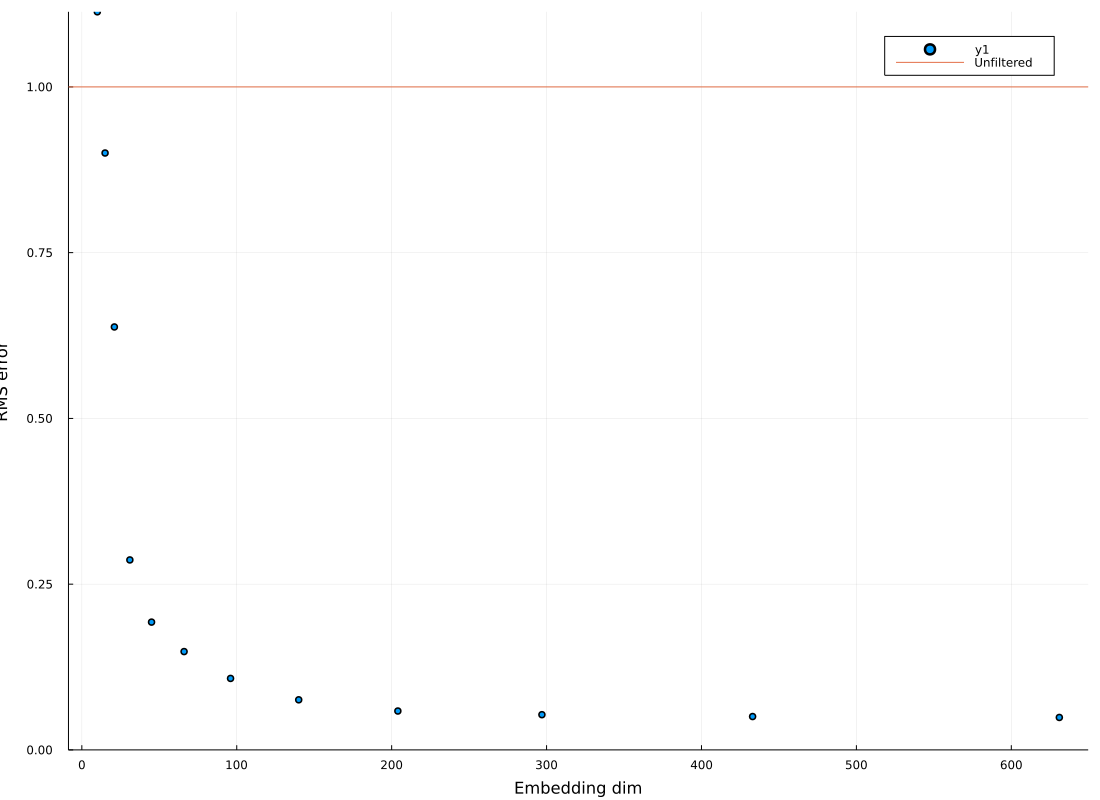

In [34]:
scatter(nvec,fits, ylabel="RMS error", xlabel="Embedding dim")
hline!([e0], lab="Unfiltered", ylims=(0,Inf))

We see that the error goes down rapidly in the beginning. One period of the smallest frequency must fit comfortably within the embedding vector, for our signal, this will be 

In [35]:
f/minimum(F)

50.0

We can also visualize the signals

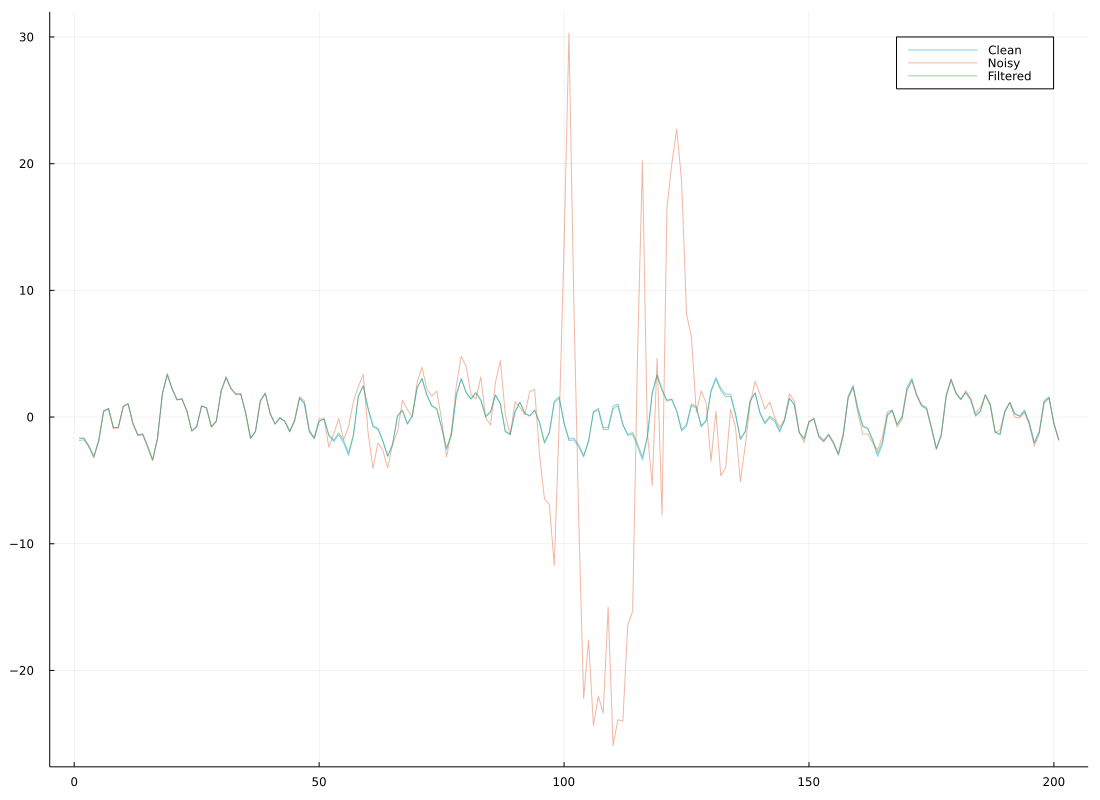

In [36]:
yh = lowrankfilter(yn, 200)

maxind = findmax(abs.(yn))[2]
plotinds = max(1,maxind-100):min(N, maxind+100)
plot([y yn yh][plotinds,:], lab=["Clean" "Noisy" "Filtered"], alpha=0.5)

We chose a small number of indices to plot, centered around the peak noise value. There should be very little difference between the clean signal and the filtered signal, while the noisy signal can deviate dramatically.

Te increased performance is, however, not for free. Increasing the dimension of the lag embedding causes the computation time to grow roughly as $\mathcal{O}(n^{1.5})$, let's have a look

In [37]:
nvec = round.(Int, exp10.(LinRange(1, 3, 12)))
times = map(nvec) do n
    @elapsed lowrankfilter(yn, n, tol=1e-3)
end;

fit[2] = 1.5217835756595879


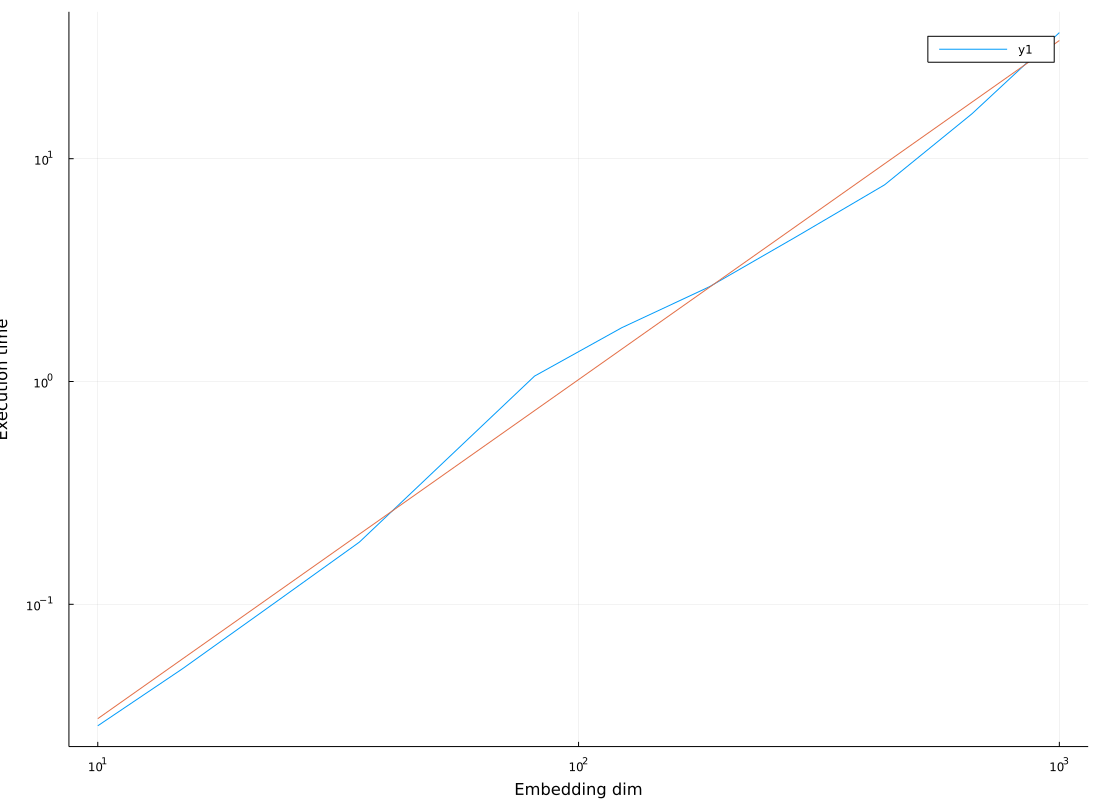

In [38]:
A = log.(nvec).^((0:1)')
fit = (A\log.(times))
@show fit[2]
plot(nvec, times, xscale=:log10, yscale=:log10, ylabel="Execution time", xlabel="Embedding dim")
plot!(nvec, exp.(A*fit), lab="")

That was all for today, happy robust filtering and estimation!